In [45]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
import math
from mpmath import *
from sympy import Symbol, solveset, S, erf, log, sqrt
from itertools import cycle
from numpy import ma
from matplotlib import ticker, cm
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
mp.dps = 2 # accuracy
mp.pretty = True

In [46]:
particle_density = 997 # kg/m^3
fluid_density = 1.255 # kg/m^3
dynamic_viscosity_air_25C = 1.849e-5
mean_free_path_air_25C = 6.826e-8

reynolds_max = None
reynolds_min = None

In [47]:
def euler(xy_n, delta_t, funcs):
    # 2D euler
    x_n = xy_n[0] + delta_t*funcs[0]
    y_n = xy_n[1] + delta_t*funcs[1]
    return [x_n, y_n]

Re = lambda v, particle_diameter: fluid_density*v*particle_diameter/dynamic_viscosity_air_25C  #not entirely accurate

# Slip correction factor
C_c = lambda particle_diameter: 1 + 2*mean_free_path_air_25C/particle_diameter*(1.257+0.4*math.e**(-1.1*particle_diameter/(2*mean_free_path_air_25C)))

def C_d(Re):
    global reynolds_max 
    global reynolds_min
    #if reynolds_max is None or Re > reynolds_max:
     #   reynolds_max = Re
    #if reynolds_min is None or Re < reynolds_min:
     #   reynolds_min = Re
    if Re < 0.1:
        return 24/Re
    elif Re > 0.1 and Re < 0.2:
        return 24/Re*(1+3/16*Re+9/160*Re**2*log(2*Re))
    elif Re > 0.2 and Re < 500:
        return 24/Re*(1+0.15*Re**0.686)
    elif Re > 500 and Re < 2e5:
        return 0.44
    elif Re > 2e5:
        raise Exception('Reynolds number to large')
    
def F_drag(v, particle_diameter):
    # also add drag force = 0 if velocity is 0
    if particle_diameter <= 10e-6:
        return (3*math.pi*dynamic_viscosity_air_25C*v*particle_diameter)/(C_c(particle_diameter)*(2/particle_diameter))
    else:
        return math.pi/8*C_d(Re(v, particle_diameter))*fluid_density*particle_diameter**2*v**2

F_g = lambda particle_mass: particle_mass*constants.g
F_b = lambda particle_volume: fluid_density*particle_volume*constants.g

def acceleration(v, particle_mass, particle_diameter, particle_volume):
    speed = (v[0]**2+v[1]**2)**(1/2)
    velocity_unitvector_x = v[0]/speed
    velocity_unitvector_y = v[1]/speed
    drag_force = F_drag(speed, particle_diameter)
    drag_force_x = -1*velocity_unitvector_x*drag_force
    drag_force_y = -1*velocity_unitvector_y*drag_force

    a_x = drag_force_x/particle_mass
    a_y = (-F_g(particle_mass) + drag_force_y + F_b(particle_volume))/particle_mass
    #print(f'{v = }\n', f'{speed = }\n', f'{velocity_unitvector_x = }\n', f'{velocity_unitvector_y = }\n', f'{drag_force = }\n', f'{drag_force_x = }\n', f'{drag_force_y = }\n', f'{a_x = }\n',f'{a_y = }\n\n')

    return [a_x, a_y]

def euler_step(v, pos, delta_t, particle_mass, particle_diameter, particle_volume, air_velocity_field):
    # velocity field
    v_air =  air_velocity_field(pos)
    v_actual = np.add(v, v_air)
    
    pos_new = euler(pos, delta_t, v_actual)
    a_new = acceleration(v_actual, particle_mass, particle_diameter, particle_volume)
    v_new = euler(v_actual, delta_t, a_new)
    
    return {
        'a': a_new,
        'v': v_new,
        'pos': pos_new
    }

In [48]:
def particle_simulation(particle_diameter, v_init, pos_init, experiment_time, delta_t, air_velocity_field):
    particle_volume = 4/3*math.pi*(particle_diameter/2)**3
    particle_mass = particle_volume*particle_density

    steps = np.arange(0, experiment_time, delta_t)
    n_steps = math.ceil(experiment_time/delta_t)
    v = np.zeros(shape=(n_steps + 1, 2))
    pos = np.zeros(shape=(n_steps + 1, 2))
    
    v[0] = v_init
    pos[0] = pos_init
    
    for id, step in enumerate(steps):
        # compute new values
        new_values = euler_step(v[id], pos[id], delta_t, particle_mass, particle_diameter, particle_volume, air_velocity_field)

        # add new values
        v[id+1] = new_values['v']
        pos[id+1] = new_values['pos']

    return {
        'v': v,
        'pos': pos
    }

In [97]:
simulations = [
    {
        'type': 'speech',
        'd': [100e-6, 1000e-6],
        'v': [5, 0]
    },
    {
        'type': 'speech',
        'd': [100e-6, 1000e-6],
        'v': [10, 0]
    },
    {
        'type': 'speech',
        'd': [100e-6, 1000e-6],
        'v': [17, 0]
    },
    {
        'type': 'cough',
        'd': [1e-6, 100e-6, 1000e-6],
        'v': [20, 0]
    }
]

simulations_test = [
    {
        'type': 'cough',
        'd': [1e-6],
        'v': [20, 2]
    }
]

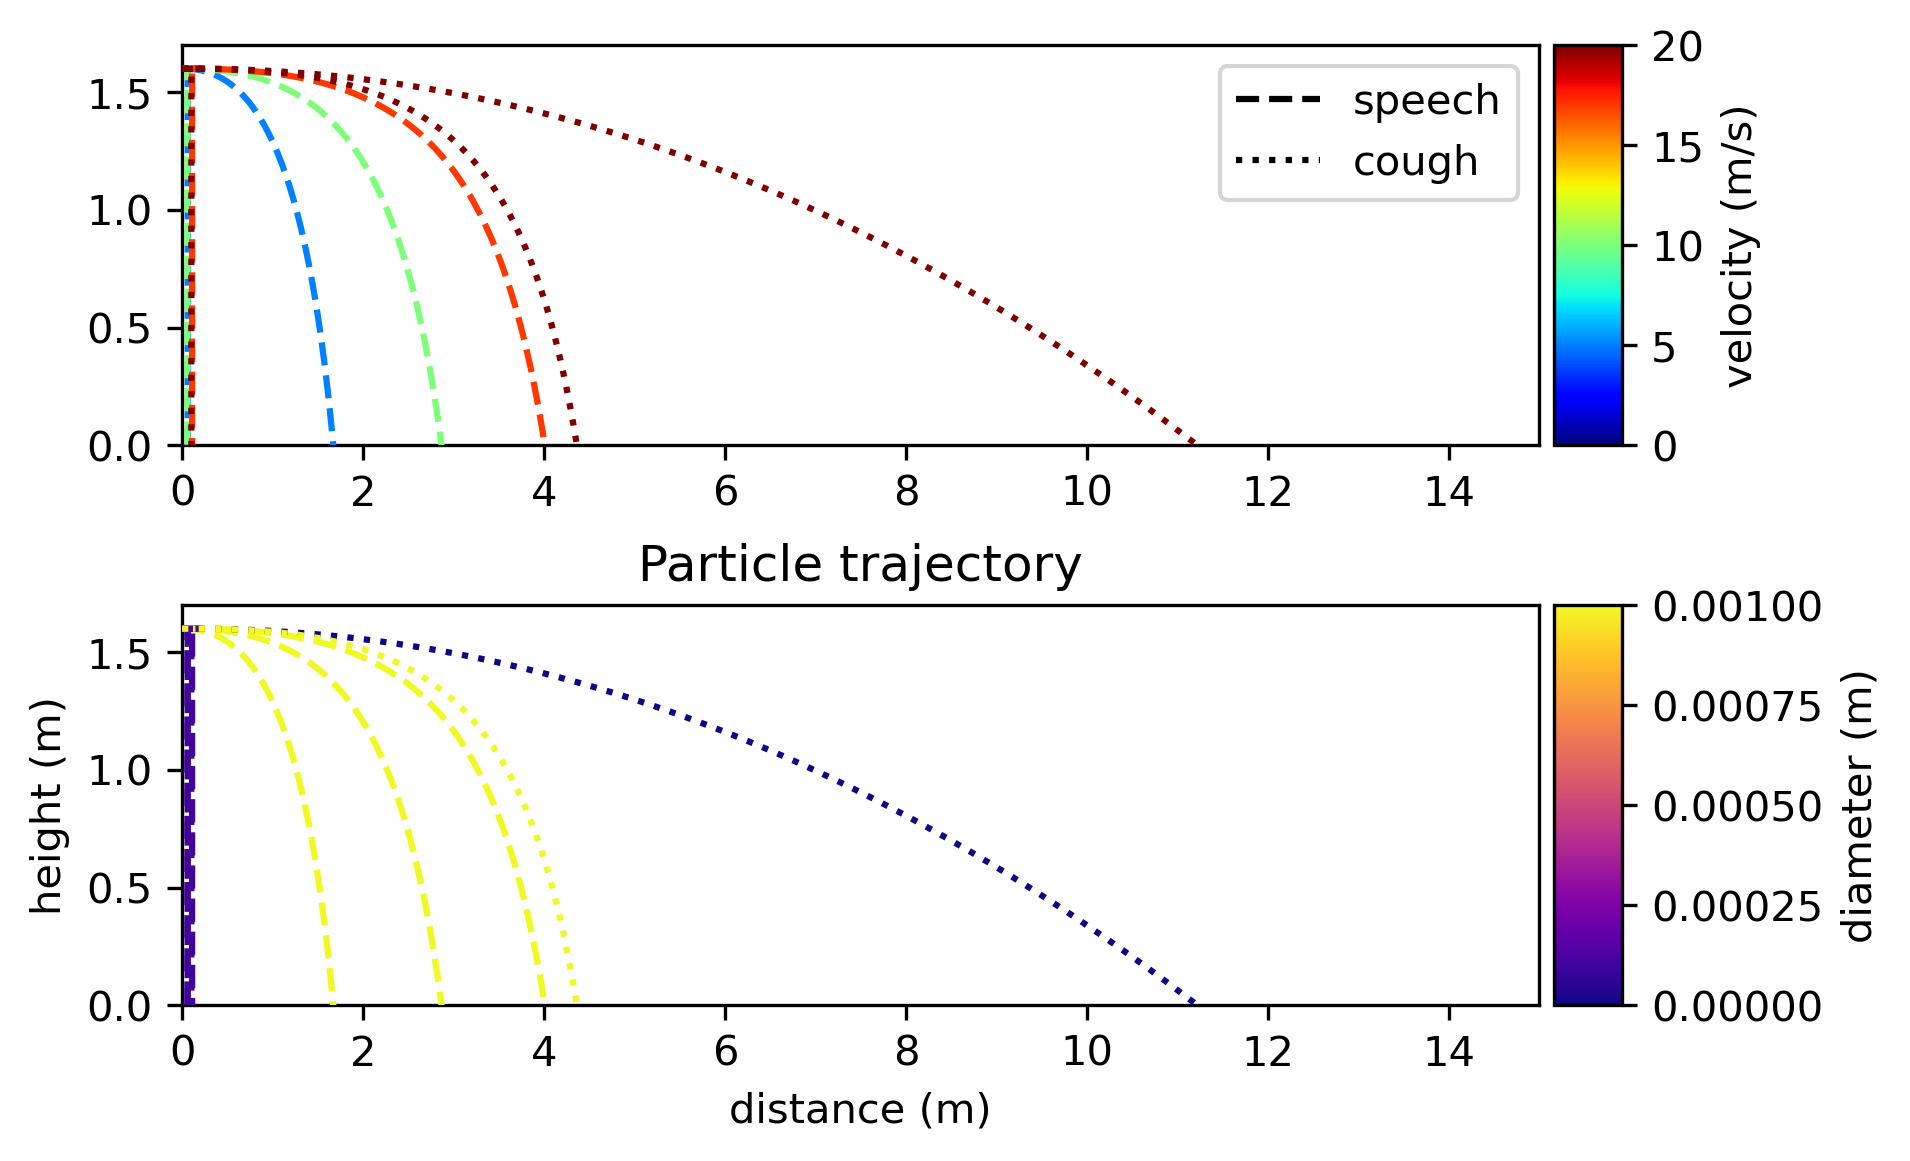

In [50]:
experiment_time = 20
delta_t = 0.01
pos_init = [0, 1.6]
air_velocity_field = lambda pos: [0,0]
u, v = 0, 0.04 # air velocity field

fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)

ax1.set_xlim([0, 15])
ax1.set_ylim([0, 1.7])
ax2.set_xlim([0, 15])
ax2.set_ylim([0, 1.7])

plt.title('Particle trajectory')
plt.xlabel('distance (m)')
plt.ylabel('height (m)')
fig.set_dpi(300)

color_map_v = plt.cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=0, vmax=20))
color_map_d = plt.cm.ScalarMappable(cmap=cm.plasma, norm=plt.Normalize(vmin=0, vmax=1000e-6))

for simulation in simulations:
    for particle_diameter in simulation['d']:
        res = particle_simulation(particle_diameter, simulation['v'], pos_init, experiment_time, delta_t, air_velocity_field)        
        # extract axes from position list
        pos_x = list(map(lambda xy: xy[0], res['pos']))
        pos_y = list(map(lambda xy: xy[1], res['pos']))
        #linestyle=':' if simulation['type'] == 'speech' else 'dotted', label=simulation['label']
        ax1.plot(pos_x, pos_y, c=color_map_v.to_rgba(simulation['v'][0]), linestyle='dashed' if simulation['type'] == 'speech' else 'dotted', zorder=100)
        ax2.plot(pos_x, pos_y, c=color_map_d.to_rgba(particle_diameter), linestyle='dashed' if simulation['type'] == 'speech' else 'dotted', zorder=100)
        
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)        
fig.colorbar(color_map_v, label='velocity (m/s)', cax=cax, orientation='vertical')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(color_map_d, label='diameter (m)', cax=cax, orientation='vertical')

lineSpeech = Line2D([0,1],[0,1],linestyle='dashed', color='black')
lineCough = Line2D([0,1],[0,1],linestyle='dotted', color='black')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

ax1.legend([lineSpeech, lineCough],['speech', 'cough'])

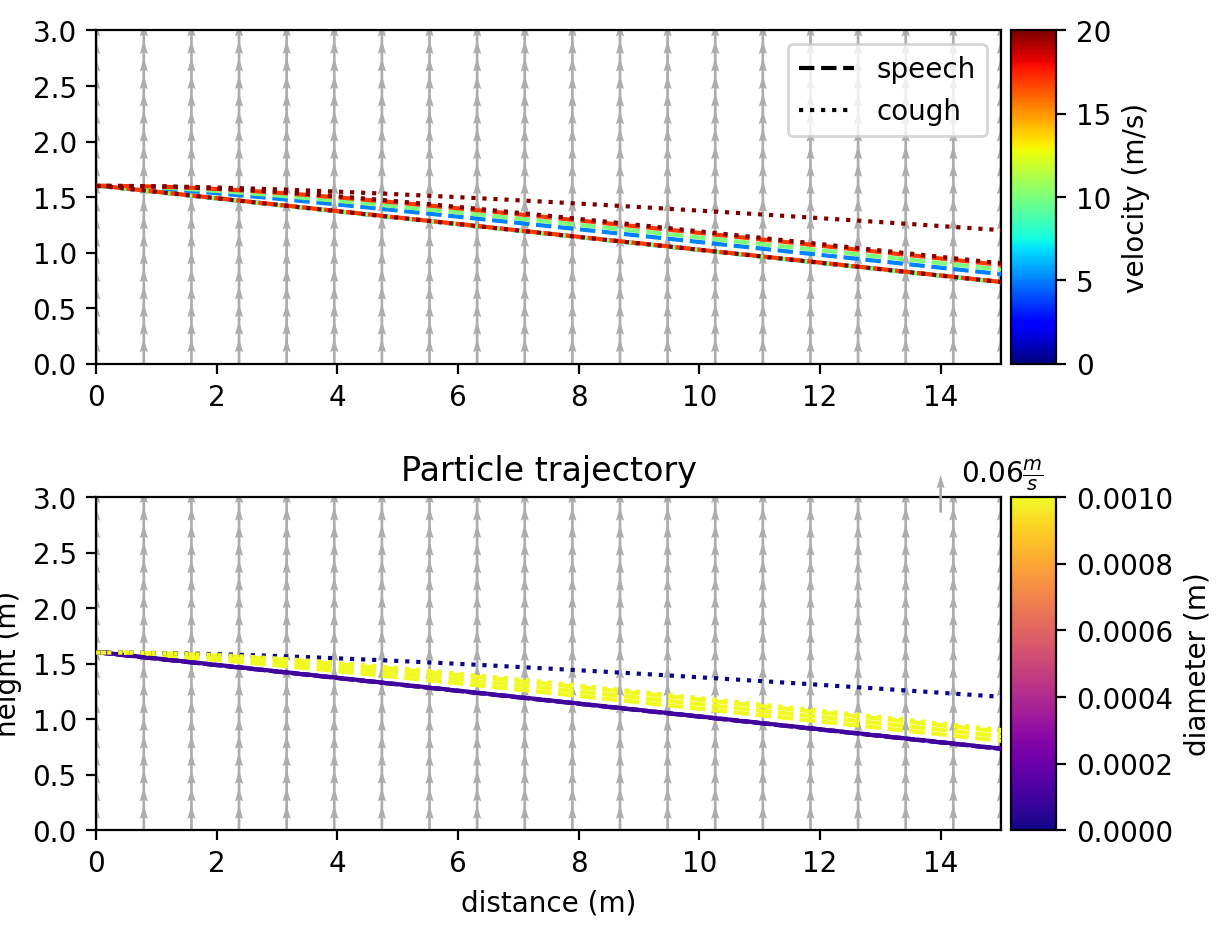

In [84]:
experiment_time = 20
delta_t = 0.01
pos_init = [0, 1.6]
air_velocity_field = lambda pos: [1,0.04]
u, v = 0, 0.04 # air velocity field

fig, [ax1, ax2] = plt.subplots(nrows=2, ncols=1)

ax1.set_xlim([0, 15])
ax1.set_ylim([0, 3])
ax2.set_xlim([0, 15])
ax2.set_ylim([0, 3])

plt.title('Particle trajectory')
plt.xlabel('distance (m)')
plt.ylabel('height (m)')
fig.set_dpi(200)

color_map_v = plt.cm.ScalarMappable(cmap=cm.jet, norm=plt.Normalize(vmin=0, vmax=20))
color_map_d = plt.cm.ScalarMappable(cmap=cm.plasma, norm=plt.Normalize(vmin=0, vmax=1000e-6))

for simulation in simulations:
    for particle_diameter in simulation['d']:
        res = particle_simulation(particle_diameter, simulation['v'], pos_init, experiment_time, delta_t, air_velocity_field)        
        # extract axes from position list
        pos_x = list(map(lambda xy: xy[0], res['pos']))
        pos_y = list(map(lambda xy: xy[1], res['pos']))
        #linestyle=':' if simulation['type'] == 'speech' else 'dotted', label=simulation['label']
        ax1.plot(pos_x, pos_y, c=color_map_v.to_rgba(simulation['v'][0]), linestyle='dashed' if simulation['type'] == 'speech' else 'dotted', zorder=100)
        ax2.plot(pos_x, pos_y, c=color_map_d.to_rgba(particle_diameter), linestyle='dashed' if simulation['type'] == 'speech' else 'dotted', zorder=100)
        
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)        
fig.colorbar(color_map_v, label='velocity (m/s)', cax=cax, orientation='vertical')
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(color_map_d, label='diameter (m)', cax=cax, orientation='vertical')

lineSpeech = Line2D([0,1],[0,1],linestyle='dashed', color='black')
lineCough = Line2D([0,1],[0,1],linestyle='dotted', color='black')

#quiver
x_mesh,y_mesh = np.meshgrid(np.linspace(0,15,20), np.linspace(0,3,20))
qv1 = ax1.quiver(x_mesh, y_mesh, u, v, color='#adadad', zorder=0)
qv2 = ax2.quiver(x_mesh, y_mesh, u, v, color='#adadad', zorder=0)
plt.quiverkey(qv2, 14, 3.2, 0.06, r'$0.06\frac{m}{s}$', coordinates='data', angle=90, labelpos='E')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1.1, 
                    wspace=0.4, 
                    hspace=0.4)

ax1.legend([lineSpeech, lineCough],['speech', 'cough'])

In [90]:
stream_traces = pd.read_csv('./export_stream_trace.csv')

In [91]:
stream_traces_i = stream_traces
#stream_traces_i = pd.concat([stream_traces, pd.DataFrame({'Points:0':np.arange(0, 15, 0.001), 'Points:1': np.arange(0, 15, 0.001)})], ignore_index=True, axis=0)
#stream_traces_i = stream_traces_i.interpolate()
#stream_traces.sort_values('Points:0')

In [99]:
def find_neighbours(value, df, colname):
    try:
        exactmatch = df[df[colname] == value]
        if not exactmatch.empty:
            return exactmatch.index
        else:
            lowerneighbour_ind = df[df[colname] < value][colname].idxmax()
            upperneighbour_ind = df[df[colname] > value][colname].idxmin()
            return [lowerneighbour_ind, upperneighbour_ind]
    except ValueError:
        print('value')
        return [1]

In [125]:
simulations_test = [
    {
        'type': 'cough',
        'd': [10e-6],
        'v': [-20, 2]
    }
]

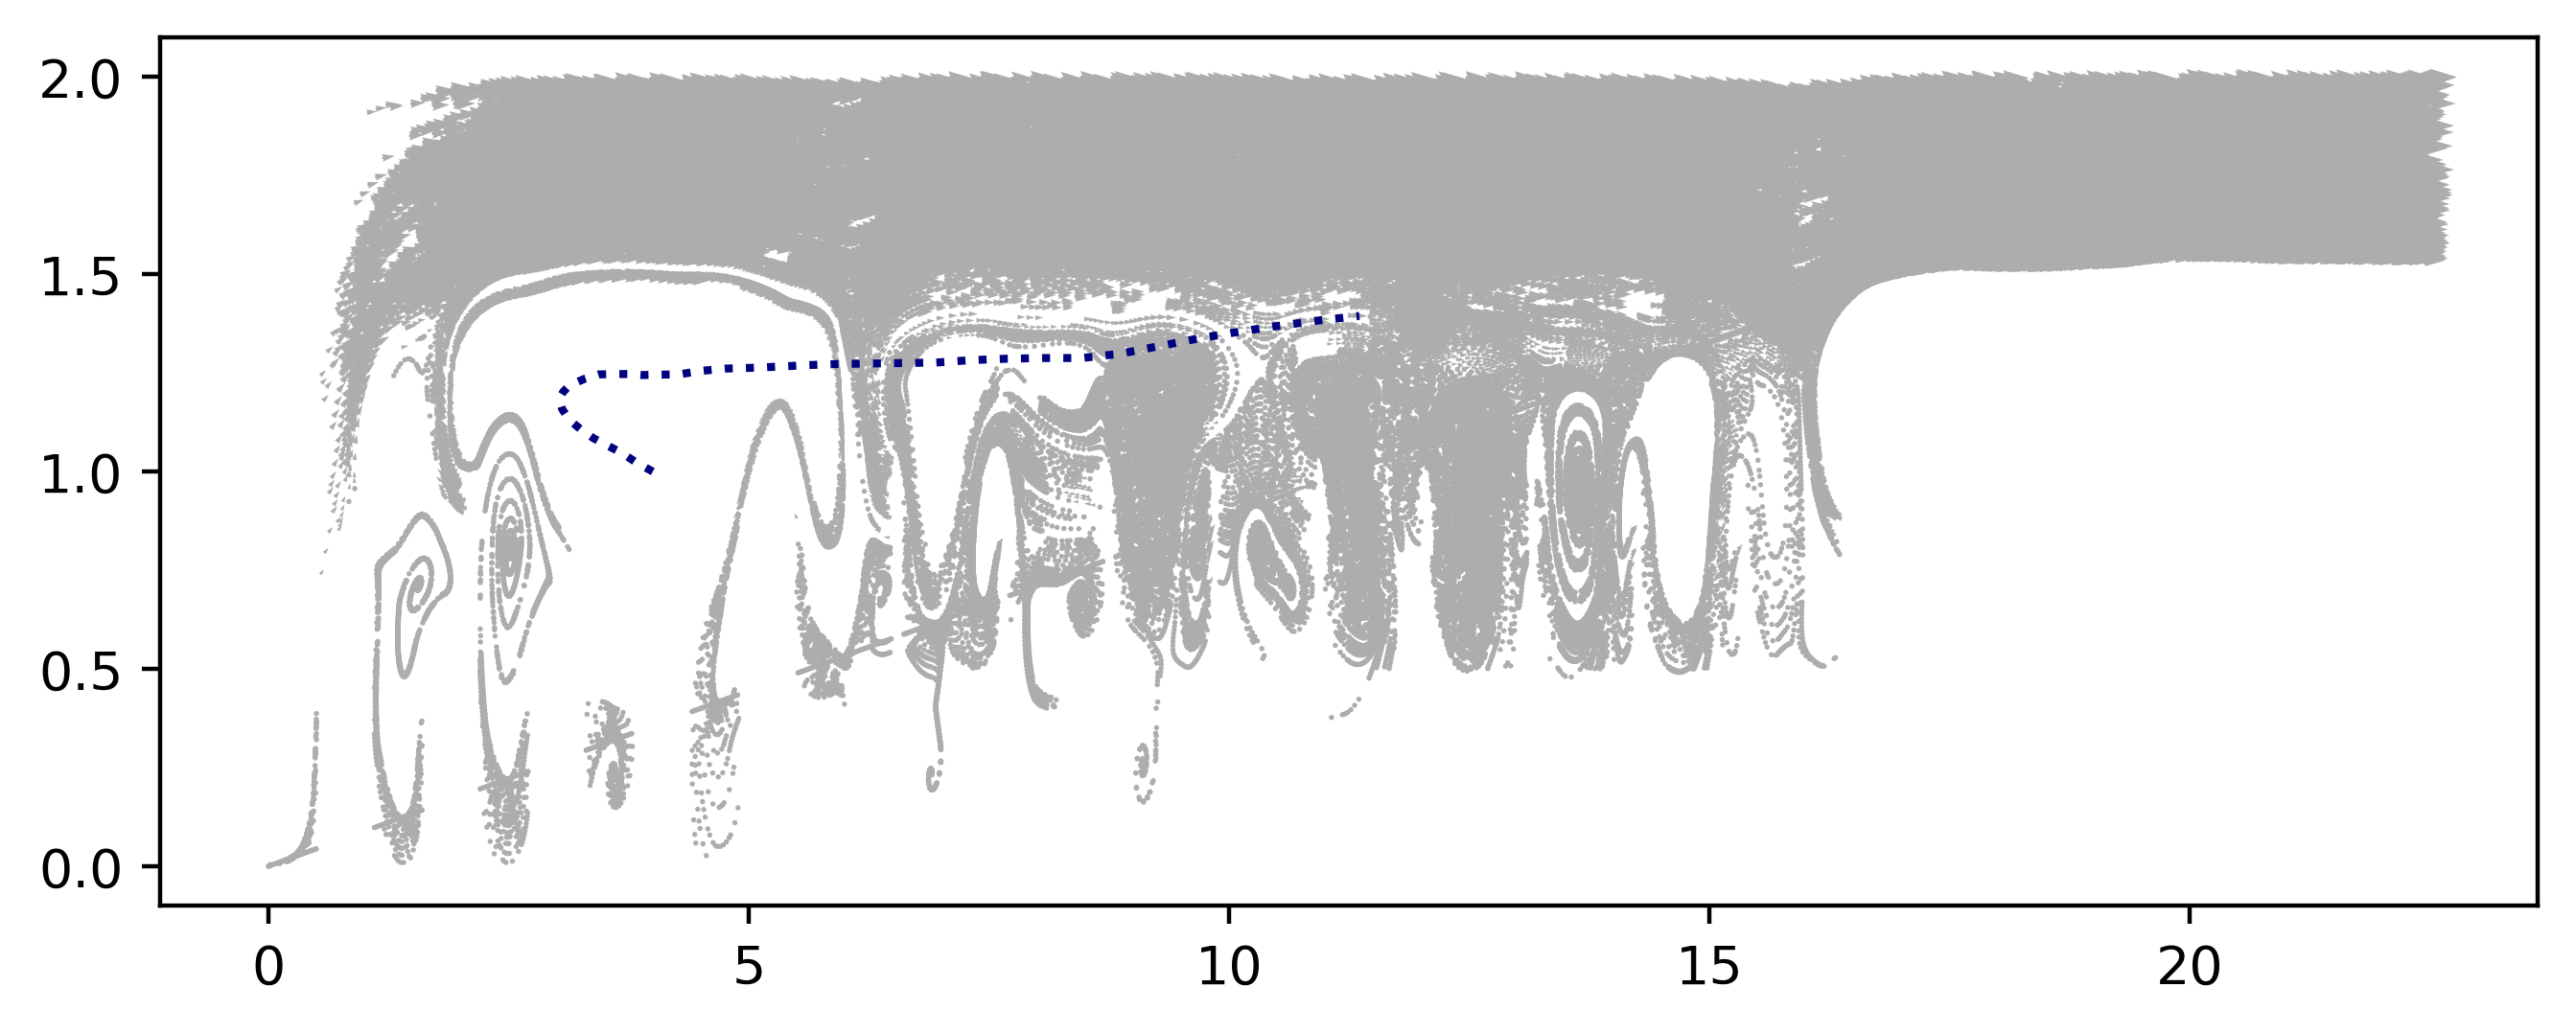

In [127]:
air_velocity_field = lambda pos: pos[0]
experiment_time = 0.4
delta_t = 0.01
pos_init = [4, 1]

fig, ax = plt.subplots(figsize=(8,3))
fig.set_dpi(400)

def air_velocity_field(pos):
    # find the closest available position from the interpolated data
    #find_neighbours(pos[0], stream_traces_i, 'Points:0')
    #nearest_x = stream_traces_i.at[find_neighbours(pos[0], stream_traces_i, 'Points:0')[0], 'Points:0']
    #nearest_y = stream_traces_i.at[find_neighbours(pos[1], stream_traces_i, 'Points:1')[0], 'Points:1']
    #u_x = stream_traces_i[stream_traces_i['Points:0'] == nearest_x]['U:0'].values[0]
    #u_y = stream_traces_i[stream_traces_i['Points:1'] == nearest_y]['U:1'].values[0]
    u_x = stream_traces_i.iloc[(stream_traces_i['Points:0']-pos[0]).abs().argsort()[:1]]['U:0'].values[0]
    u_y = stream_traces_i.iloc[(stream_traces_i['Points:1']-pos[1]).abs().argsort()[:1]]['U:1'].values[0]
    return [u_x, u_y]

for simulation in simulations_test:
    for particle_diameter in simulation['d']:
        res = particle_simulation(particle_diameter, simulation['v'], pos_init, experiment_time, delta_t, air_velocity_field)        
        # extract axes from position list
        pos_x = list(map(lambda xy: xy[0], res['pos']))
        pos_y = list(map(lambda xy: xy[1], res['pos']))
        #linestyle=':' if simulation['type'] == 'speech' else 'dotted', label=simulation['label']
        ax.plot(pos_x, pos_y, c=color_map_v.to_rgba(simulation['v'][0]), linestyle='dashed' if simulation['type'] == 'speech' else 'dotted', zorder=100)
        #ax2.plot(pos_x, pos_y, c=color_map_d.to_rgba(particle_diameter), linestyle='dashed' if simulation['type'] == 'speech' else 'dotted', zorder=100)
        
ax.quiver(stream_traces_i['Points:0'], stream_traces_i['Points:1'], stream_traces_i['U:0'], stream_traces_i['U:1'], color='#adadad', zorder=0)